
# MIT Critical Data
## Mortality Prediction
### F.A.I.T.H. Hackathon

## Import Libraries

In [13]:
import pandas as pd


import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.metrics import *
from joblib import Parallel, delayed
from sklearn.base import clone
from time import time
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Now, let's mount our Google Drive to the Colab notebook so that we can access the files in your GDrive folders.
For this, Google will ask you to authenticate before you can use the directory. Simply follow the link which is been shown in the output, login to your Google account and (after authorization) copy the code to the input field which comes after the link in the output below and **press Enter**.
After this step has successfully completed, the dataset will automatically be downloaded.

-*Note*-: *By downloading the dataset below, you agree that you won't reuse it for commercial or research purposes. We grant access to the dataset only for the duration of the F.A.I.T.H event (25.-26.07.2020).*

After downloading the dataset to the Google Colab dir, read and parse it into the variable df.

Now, we print the first 5 lines of the dataset to check if everything worked out correctly. After this, you can start analyzing your data with Pandas, matplotlib and build models with sklearn. For the internal hackathon ranking, we ask you to build these models in a sklearn-compatible fashion so that we can easily re-run the models with our own internal test set.

# Custom defined functions

In [150]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [151]:
def preproc_train(data, test_data, redundant_columns, ohe_columns):
    data = data.drop(redundant_columns,axis=1)
    data = data.loc[:, data.isna().mean() <= .8]
    
    data.fillna(data.median(axis = 0, skipna = True), inplace=True)
    data = correlation(data, 0.9)
    a = data.columns
    data1 = data[ohe_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))
    data1 = pd.get_dummies(data1)
  

    data2 = data.drop(ohe_columns, axis = 1)
    x = data2.values
    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    data2 = pd.DataFrame(x , columns = data2.columns)
    data = pd.merge(data1, data2, on=data1.index, how='outer')
    data = data.drop('key_0', axis = 1)

    test_data = test_data.drop(redundant_columns,axis=1)
    test_data = test_data.loc[:,a]
    test_data.fillna(data.median(axis = 0, skipna = True), inplace=True)

    test_data1 = test_data[ohe_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))
    test_data1 = pd.get_dummies(test_data1)

    test_data2 = test_data.drop(ohe_columns, axis = 1)
    x = test_data2.values
    x = scaler.transform(x)
    test_data2 = pd.DataFrame(x , columns = test_data2.columns)
    test_data = pd.merge(test_data1, test_data2, on=test_data1.index, how='outer')
    test_data = test_data.drop('key_0', axis = 1)
    test_data = test_data.loc[:,data.columns]
    

    return data, test_data

In [152]:
def fit_and_score(model, train_index, valid_index, X, Y):
    # get X and y vectors
    x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
       
    # train model
    model.fit(x_train, y_train)
    
    # append scores
    y_train_preds = model.predict(x_train)
    y_valid_preds = model.predict(x_valid)
    
    f1_train = f1_score(y_train, y_train_preds)
    roc_train = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
    mcc_train = matthews_corrcoef(y_train, y_train_preds)
    
    f1_val = f1_score(y_valid, y_valid_preds)
    roc_val = roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])
    mcc_val = matthews_corrcoef(y_valid, y_valid_preds)
    
    log_line = 'Train score: ' + str(roc_train) + ' Validation score: ' + str(roc_val)
    tqdm.write(log_line)
    
    return roc_train, roc_val, f1_train, f1_val, mcc_train, mcc_val

In [153]:
def specificity(y_truth, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Code

In [154]:
#Set Seed
np.random.seed(13)

In [155]:
#Load data
df = pd.read_csv('/Users/ks/Desktop/dataset_main.csv')

In [156]:
x = df.drop("hospital_death", axis=1)
y = df['hospital_death']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1)

In [157]:
red_cols =  ['encounter_id', 'patient_id', 'hospital_id', 'height', 'hospital_admit_source','icu_admit_source', 'icu_id', 'icu_type','weight',]
ohe_cols = ['ethnicity', 'gender', 'icu_stay_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']

Preprocess Train and Test

In [158]:
#x_train = x
x_train, x_test = preproc_train(x_train, x_test, red_cols, ohe_cols)

## **Models**

**Logistic Regression**

In [96]:
model = LogisticRegression(class_weight = {1:y_train.value_counts()[0], 0: y_train.value_counts()[1]}, max_iter = 500, n_jobs = -1)

**Random Forest**

In [97]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators = 700, n_jobs= -1, 
                               verbose = 1, class_weight = {1:y_train.value_counts()[0], 0: y_train.value_counts()[1]})

#### LightGBM

In [165]:
from lightgbm.sklearn import LGBMClassifier
model = LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.005,
                       n_estimators = 200, objective = 'binary',
                       scale_pos_weight =y_train.value_counts()[0]/y_train.value_counts()[1], njobs = -1)

### K-fold Cross Validation

In [166]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(n_splits=5, shuffle=True)
n_jobs = -1  

In [167]:
st = time()

if n_jobs == 1:
    print('Running single process loop')
    res = []

    for train_index, valid_index in tqdm(kfolds.split(x_train, y_train)):
        res.append(fit_and_score(clone(model), train_index, valid_index, x_train, y_train))
else:
    print('Running parallel loop')
    parallel = Parallel(n_jobs=n_jobs, verbose=1)
    res = parallel(delayed(fit_and_score)(clone(model), train_idx, valid_idx, x_train, y_train)
              for train_idx, valid_idx in kfolds.split(x_train, y_train))
        
        
end = time()

print('Total time taken ', (end - st)/60, ' mins')

Running parallel loop


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Total time taken  1.1116745789845786  mins


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [168]:
res = pd.DataFrame(res, columns=['ROC_train', 'ROC_val', 'F1_train', 'F1_val', 'MCC_train', 'MCC_val'])
res

,ROC_train,ROC_val,F1_train,F1_val,MCC_train,MCC_val
0,0.902430,0.884888,0.499646,0.494978,0.450240,0.445087
1,0.903825,0.880729,0.502340,0.483464,0.453237,0.432513
2,0.902984,0.883544,0.498061,0.497046,0.448488,0.447449
3,0.904400,0.875320,0.506096,0.466691,0.457447,0.413970
4,0.903792,0.875571,0.502704,0.479033,0.453718,0.427365


### Train on entire dataset

In [163]:
model.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, njobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=10.653333333333334, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Feature Importance

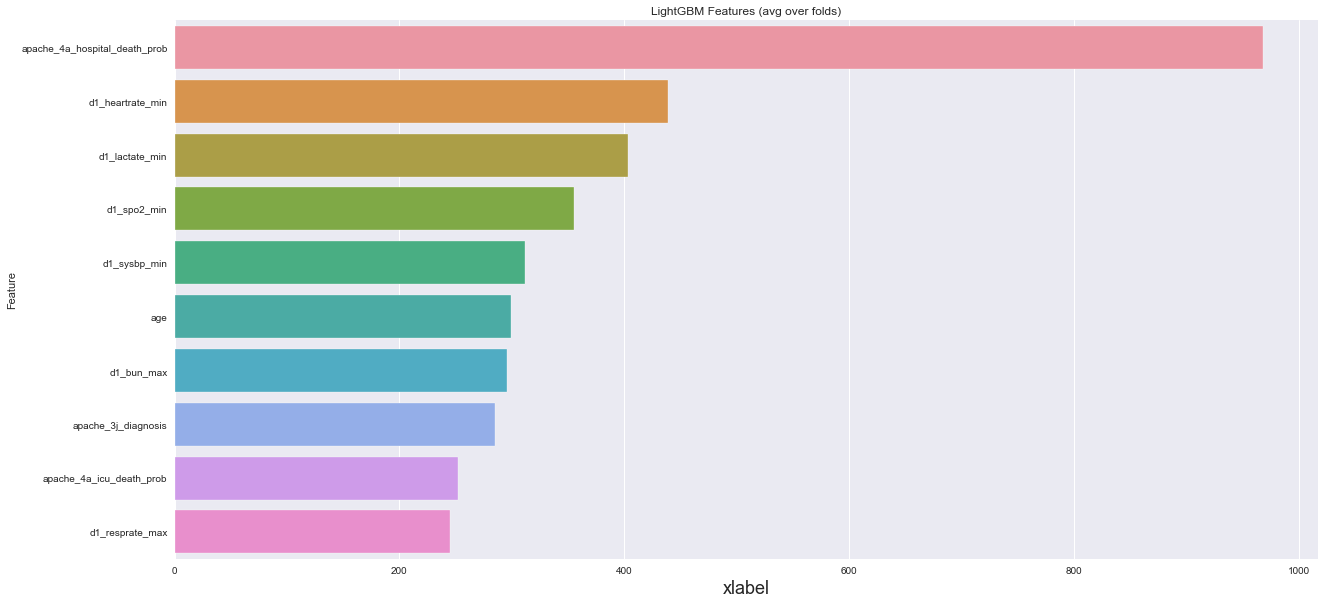

<Figure size 576x396 with 0 Axes>

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('LightGBM Features (avg over folds)')
plt.xlabel('xlabel', fontsize=18)
plt.tight_layout()

plt.show()
plt.savefig('lgbm_importances-01.png')

**Model performance on test**

In [110]:
y_train_preds = model.predict_proba(x_train)[:,1]
train_score = roc_auc_score(y_train,y_train_preds)

y_test_preds = model.predict_proba(x_test)[:,1]
test_score = roc_auc_score(y_test,y_test_preds)

print('Training score: ', train_score)
print('Testing score: ', test_score)
print(classification_report(y_test, model.predict(x_test)))

Training score:  0.9050402854431499
Testing score:  0.8607550982232046
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7556
           1       0.31      0.74      0.44       699

    accuracy                           0.84      8255
   macro avg       0.64      0.79      0.67      8255
weighted avg       0.92      0.84      0.87      8255



In [111]:
print('Accuracy: ', accuracy_score(y_test, model.predict(x_test)))

print('Precision: ', precision_score(y_test, model.predict(x_test)))
print('recall: ', recall_score(y_test, model.predict(x_test)))
print('Specificity:',specificity(y_test, model.predict(x_test)))
print('F1 Score: ', f1_score(y_test, model.predict(x_test)))
print('Testing score: ', test_score)

Accuracy:  0.8390066626287098
Precision:  0.3104693140794224
recall:  0.7381974248927039
Specificity: 0.8483324510322923
F1 Score:  0.4371029224904702
Testing score:  0.8607550982232046
